In [18]:
import deepxde as dde
import numpy as np
import torch 

In [19]:
#CUDA
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

#PARÂMETROS DOMINIO
L = 2
TF = 80

#PARAMETROS
D = 0.0039
P = 0.0453
c0 = 8e3
Dl = D / (P * L**2)

#PARÂMETROS TREINAMENTO
NUM = 5000
EPOCHS = 5000

#DECLARAÇÃO DOMÍNIO ESPACIAL E TEMPORAL
geom = dde.geometry.Rectangle([-1, -1], [1, 1])
time = dde.geometry.TimeDomain(0, TF * P)
geomtime = dde.geometry.GeometryXTime(geom, time)

#EQUAÇÃO RESIDUAL
def pde(x, c):
    c_t = dde.grad.jacobian(c, x, i=0, j=2)
    c_xx = dde.grad.hessian(c, x, i=0, j=0)
    c_yy = dde.grad.hessian(c, x, i=0, j=1)
    return c_t - (Dl * (c_xx + c_yy) + c)

#CONDIÇÃO INICIAL
def ic_func(x): return L**3 * np.exp(-100 * (x[:, 0:1]**2 + x[:, 1:2]**2))
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
BC = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary.on)

#DECLARAÇÃO TREINAMENTO
DATA = dde.data.TimePDE(
    geomtime,
    pde,
    [IC, BC],
    num_domain = NUM,
    num_boundary = NUM,
    num_initial = NUM,
)

LAYERS = [3] + [60] * 5 + [1]
ACTIVATION = "tanh"
INIT = "Glorot uniform"
NET = dde.nn.FNN(LAYERS, ACTIVATION, INIT)

#COMPILAÇÃO
MODEL = dde.Model(DATA, NET)
MODEL.compile("adam", lr=1e-3)
losshistory, train_state = MODEL.train(iterations=EPOCHS)
#MODEL.compile("L-BFGS-B")
#losshistory, train_state = MODEL.train(iterations=1000)

Compiling model...
'compile' took 0.000231 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.83e-01, 3.86e-01, 7.74e-02]    [4.83e-01, 3.86e-01, 7.74e-02]    []  
1000      [1.10e-02, 3.06e-03, 2.65e-04]    [1.10e-02, 3.06e-03, 2.65e-04]    []  
2000      [1.25e-03, 4.05e-04, 9.50e-05]    [1.25e-03, 4.05e-04, 9.50e-05]    []  
3000      [5.08e-04, 1.82e-04, 4.82e-05]    [5.08e-04, 1.82e-04, 4.82e-05]    []  
4000      [2.88e-04, 1.11e-04, 3.20e-05]    [2.88e-04, 1.11e-04, 3.20e-05]    []  
5000      [1.97e-04, 7.63e-05, 2.27e-05]    [1.97e-04, 7.63e-05, 2.27e-05]    []  

Best model at step 5000:
  train loss: 2.96e-04
  test loss: 2.96e-04
  test metric: []

'train' took 237.414908 s



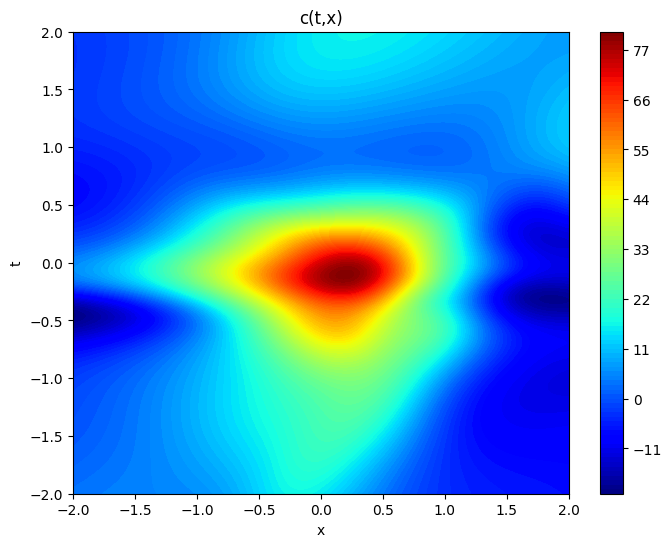

In [20]:
import matplotlib.pyplot as plt
SIZE = 1000
X = np.linspace(-1, 1, SIZE)
Y = np.linspace(-1, 1, SIZE)
T = 100 * P

X, Y = np.meshgrid(X, Y)

def predict(x, y, t):
    return MODEL.predict(np.vstack([x.ravel(), y.ravel(), np.full_like(x.ravel(), t)]).T).reshape(x.shape)

OUT = predict(X, Y, T) * (c0 / (L)**3)

plt.figure(figsize=(8, 6))
plt.contourf(X * L, Y * L, OUT, 100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('c(t,x)')
plt.show()